In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sn

import cv2
from random import randint

import numpy as np

## Check Data 

In [2]:
CLASSES, gems = [], [] # names of classes, count of images for each class

for root, dirs, files in os.walk('C:/Users/User/Desktop/Research Project/images'):
    f = os.path.basename(root)    # get class name - Red,Blue etc    
        
    if len(files) > 0:
        gems.append(len(files))
        if f not in CLASSES:
            CLASSES.append(f) # add folder name
    
     #uncomment this block if you want a text output about each subfolder
    #count_dirs = 0
    #for f in dirs:           # count subfolders
        #count_dirs += 1
    #depth = root.split(os.sep)
    #print((len(depth) - 2) * '--'+'>', '{}:\t {} folders, {} imgs'.format(os.path.basename(root), count_dirs, gems[-1] if gems!=[] else 0)) 
    
gems_count = len(CLASSES) # 6 = number of classes
print('{} classes with {} images in total'.format(len(CLASSES), sum(gems)))

#f, ax = plt.subplots(figsize=(15,6))
#if(gems[0])<10:
    #plt.bar(range(gems_count), gems[gems_count:], label = 'Train data')
    #plt.bar(range(gems_count), gems[0:gems_count], label = 'Test data')
#else:
    #plt.bar(range(gems_count), gems[0:gems_count], label = 'Train data')
    #plt.bar(range(gems_count), gems[gems_count:], label = 'Test data')
#ax.grid()
#ax.legend(fontsize = 12);

5 classes with 181 images in total


## Prepare Training Data

In [3]:
img_w, img_h = 220, 220    # width and height of image
train_dir = 'C:/Users/User/Desktop/Research Project/images/train'

In [4]:
def read_imgs_lbls(_dir):
    Images, Labels = [], []
    for root, dirs, files in os.walk(_dir):
        f = os.path.basename(root)  # get class name - Red, Blue, etc       
        for file in files:
            Labels.append(f)
            try:
                image = cv2.imread(root+'/'+file)              # read the image (OpenCV)
                image = cv2.resize(image,(int(img_w*1.5), int(img_h*1.5)))       # resize the image (images are different sizes)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) # converts an image from BGR color space to HSV
                Images.append(image)
            except Exception as e:
                print(e)
    Images = np.array(Images)
    return (Images, Labels)

In [5]:
def get_class_index(Labels):
    for i, n in enumerate(Labels):
        for j, k in enumerate(CLASSES):    # foreach CLASSES
            if n == k:
                Labels[i] = j
    Labels = np.array(Labels)
    return Labels

In [6]:
Train_Imgs, Train_Lbls = read_imgs_lbls(train_dir)
Train_Lbls = get_class_index(Train_Lbls)
print('Shape of train images: {}'.format(Train_Imgs.shape))
print('Shape of train labels: {}'.format(Train_Lbls.shape))

Shape of train images: (161, 330, 330, 3)
Shape of train labels: (161,)


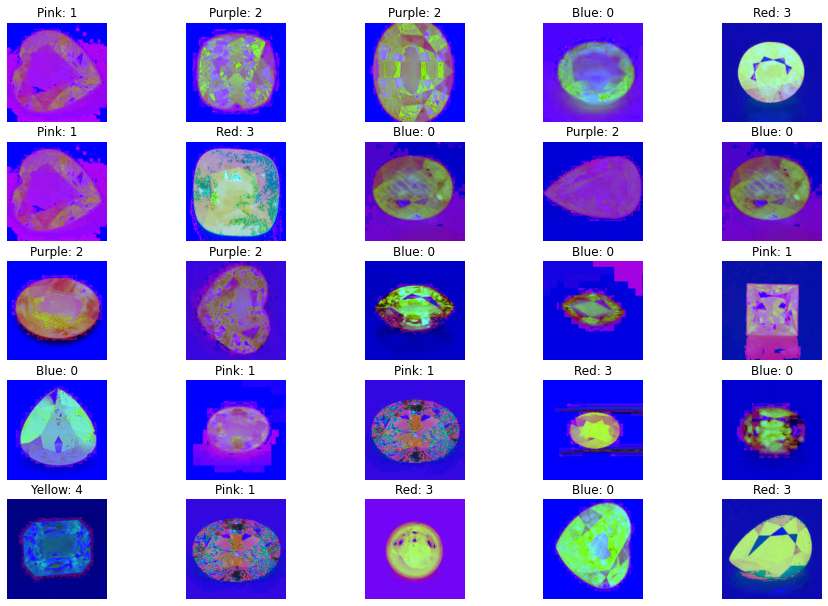

In [7]:
dim = 5 #5x5 dimension flat plot

f,ax = plt.subplots(dim,dim) 
f.subplots_adjust(0,0,2,2)
for i in range(0,dim):
    for j in range(0,dim):
        rnd_number = randint(0,len(Train_Imgs))
        cl = Train_Lbls[rnd_number]
        ax[i,j].imshow(Train_Imgs[rnd_number])
        ax[i,j].set_title(CLASSES[cl]+': ' + str(cl))
        ax[i,j].axis('off')

In [8]:
def edge_and_cut(img):
    try:
        edges = cv2.Canny(img, img_w, img_h)            
        
        if(np.count_nonzero(edges)>edges.size/10000):           
            pts = np.argwhere(edges>0)
            y1,x1 = pts.min(axis=0)
            y2,x2 = pts.max(axis=0)
            
            new_img = img[y1:y2, x1:x2]           # crop the region
            new_img = cv2.resize(new_img,(img_w, img_h))  # Convert back
        else:
            new_img = cv2.resize(img,(img_w, img_h))
    
    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(img_w, img_h))
    
    return new_img

In [9]:
def show_cropped(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, img_w, img_h)
    
    if(np.count_nonzero(edges)>edges.size/10000):
        pts = np.argwhere(edges>0)
        y1,x1 = pts.min(axis=0)
        y2,x2 = pts.max(axis=0)

        new_img = img[y1:y2, x1:x2]  

        edge_size = 1 #replace it with bigger size for larger images            

        emb_img[y1-edge_size:y1+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y2-edge_size:y2+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y1:y2, x1-edge_size:x1+edge_size] = [255, 0, 0]
        emb_img[y1:y2, x2-edge_size:x2+edge_size] = [255, 0, 0]

        new_img = cv2.resize(new_img,(img_w, img_h))  # Convert to primary size  
        
    else:
        new_img = cv2.resize(img,(img_w, img_h))
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=14)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=14)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=14)       
    ax[3].imshow(new_img, cmap='gray')
    ax[3].set_title('Cropped', fontsize=14)  

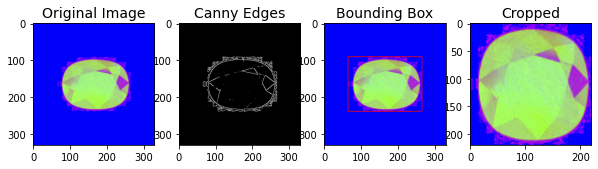

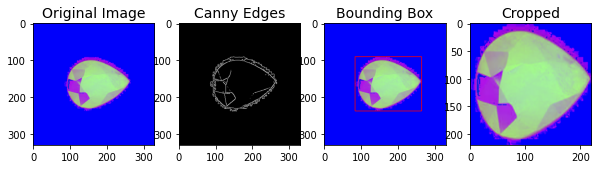

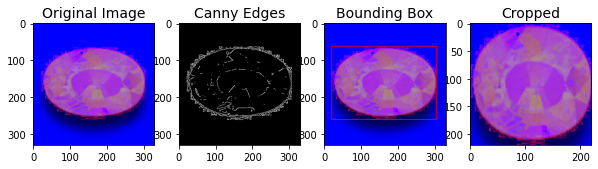

In [10]:
for x in range(0,3):
    show_cropped(Train_Imgs[randint(0,len(Train_Imgs))])

In [11]:
def crop_images(Imgs):
    CroppedImages = np.ndarray(shape=(len(Imgs), img_w, img_h, 3), dtype=np.int)

    ind = 0
    for im in Imgs: 
        x = edge_and_cut(im)
        CroppedImages[ind] = x
        ind += 1

    return CroppedImages

In [12]:
Train_Imgs = crop_images(Train_Imgs)
print('Final shape of images in train set: {} '.format(Train_Imgs.shape))

C:\Users\User\AppData\Local\Temp\ipykernel_14956\4035062776.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  CroppedImages = np.ndarray(shape=(len(Imgs), img_w, img_h, 3), dtype=np.int)


Final shape of images in train set: (161, 220, 220, 3) 


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(Train_Imgs, Train_Lbls, shuffle = True, test_size = 0.2, random_state = 42)
print('Shape of X_train: {}, y_train: {} '.format(X_train.shape, y_train.shape))
print('Shape of X_val: {}, y_val: {} '.format(X_val.shape, y_val.shape))


Shape of X_train: (128, 220, 220, 3), y_train: (128,) 
Shape of X_val: (33, 220, 220, 3), y_val: (33,) 


In [14]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D

# Build a CNN

In [15]:
filters = 32      # the dimensionality of the output space
kernel_size = 3   # length of the 2D convolution window
max_pool = 2      # size of the max pooling windows

In [16]:
EPOCHS = 70                                  # while testing you can change it
batch_size = 32                              # number of training samples using in each mini batch during GD (gradient descent) 
iter_per_epoch = len(X_train) // batch_size  # each sample will be passed [iter_per_epoch] times during training
val_per_epoch = len(X_val) // batch_size     # each sample will be passed [val_per_epoch] times during validation

In [17]:
model = Sequential()

# first layer
model.add(Conv2D(batch_size, (kernel_size, kernel_size), activation='relu', padding='same', input_shape=(img_w, img_h, 3))) # 32
model.add(MaxPooling2D((max_pool, max_pool))) #reduce the spatial size of incoming features

# second layer
model.add(Conv2D(2*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 64
model.add(MaxPooling2D((max_pool, max_pool))) 

# third layer
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(MaxPooling2D((max_pool, max_pool))) 

# fourth layer
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(AveragePooling2D(pool_size= (2, 2), strides= (2, 2))) 

# fifth layer
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(MaxPooling2D((max_pool, max_pool))) 

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(16*batch_size, activation='relu'))                                             # 512
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 55, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       1

In [18]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(              # this is the augmentation configuration used for training
        rotation_range=25,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        horizontal_flip=True
        )

val_datagen = ImageDataGenerator()                # for val/testing only rescaling function 

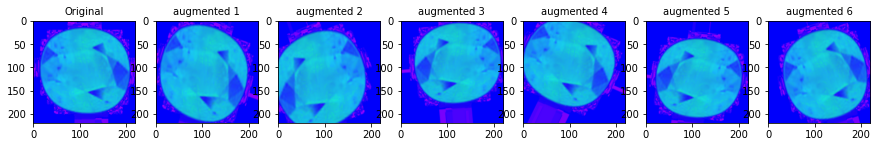

In [20]:
n = randint(0,len(X_train))
samples = np.expand_dims(X_train[n], 0)
it = train_datagen.flow(samples, batch_size=batch_size)
cols = 7

fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(15, 10))
ax[0].imshow(X_train[n], cmap='gray')
ax[0].set_title('Original', fontsize=10)

for i in range(1,cols):
    batch = it.next()    # generate batch of images 
    image = batch[0].astype('uint32') # convert to unsigned int for viewing
    ax[i].set_title('augmented {}'.format(i), fontsize=10)
    ax[i].imshow(image, cmap='gray')

In [21]:
train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_gen = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [22]:
m = model.fit_generator(
       train_gen,
       steps_per_epoch= iter_per_epoch,
       epochs=EPOCHS, 
       validation_data = val_gen,
       validation_steps = val_per_epoch,
       verbose = 1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
       )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/70
4/4 [==============================] - 16s 4s/step - loss: 34.4156 - accuracy: 0.2656 - val_loss: 2.2255 - val_accuracy: 0.3750
Epoch 2/70
4/4 [==============================] - 17s 4s/step - loss: 2.2379 - accuracy: 0.2500 - val_loss: 1.3178 - val_accuracy: 0.5000
Epoch 3/70
4/4 [==============================] - 19s 5s/step - loss: 1.3011 - accuracy: 0.4219 - val_loss: 1.5806 - val_accuracy: 0.4375
Epoch 4/70
4/4 [==============================] - 18s 5s/step - loss: 1.2711 - accuracy: 0.4531 - val_loss: 1.0820 - val_accuracy: 0.5000
Epoch 5/70
4/4 [==============================] - 22s 5s/step - loss: 0.9768 - accuracy: 0.5625 - val_loss: 0.9895 - val_accuracy: 0.5625
Epoch 6/70
4/4 [==============================] - 25s 6s/step - loss: 0.8244 - accuracy: 0.6328 - val_loss: 0.8460 - val_accuracy: 0.6250
Epoch 7/70
4/4 [==============================] - 25s 6s/step - loss: 0.7459 - accuracy: 0.6797

Epoch 58/70
4/4 [==============================] - 20s 5s/step - loss: 0.3033 - accuracy: 0.8750 - val_loss: 0.6977 - val_accuracy: 0.8125
Epoch 59/70
4/4 [==============================] - 21s 5s/step - loss: 0.3540 - accuracy: 0.8984 - val_loss: 0.9457 - val_accuracy: 0.7188
Epoch 60/70
4/4 [==============================] - 20s 5s/step - loss: 0.3570 - accuracy: 0.8828 - val_loss: 0.8273 - val_accuracy: 0.6562
Epoch 61/70
4/4 [==============================] - 19s 5s/step - loss: 0.2664 - accuracy: 0.8828 - val_loss: 0.5879 - val_accuracy: 0.7500
Epoch 62/70
4/4 [==============================] - 20s 5s/step - loss: 0.2161 - accuracy: 0.9297 - val_loss: 1.0689 - val_accuracy: 0.6875
Epoch 63/70
4/4 [==============================] - 19s 5s/step - loss: 0.3242 - accuracy: 0.8750 - val_loss: 0.7584 - val_accuracy: 0.7188
Epoch 64/70
4/4 [==============================] - 20s 5s/step - loss: 0.3091 - accuracy: 0.8750 - val_loss: 1.0746 - val_accuracy: 0.6562
Epoch 65/70
4/4 [==========

In [23]:
score = model.evaluate_generator(val_gen, steps= len(val_gen))

for idx, metric in enumerate(model.metrics_names):
    print('{}:{}'.format(metric, score[idx]))

Instructions for updating:
Please use Model.evaluate, which supports generators.
loss:0.8286617994308472
accuracy:0.7878788113594055


<AxesSubplot:>

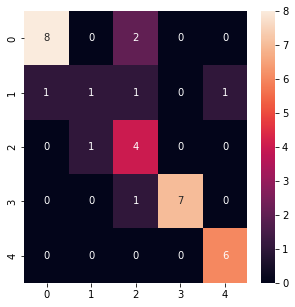

In [32]:
from sklearn.metrics import confusion_matrix
y_pre_test=model.predict(X_val)
y_pre_test=np.argmax(y_pre_test,axis=1)
cm=confusion_matrix(y_val,y_pre_test)

plt.figure(figsize = (5,5))
sn.heatmap(cm, annot=True)

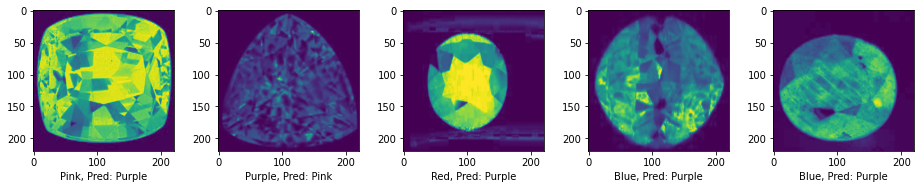

In [33]:
x=(y_pre_test-y_val!=0).tolist()
x=[i for i,l in enumerate(x) if l!=False]

fig,ax=plt.subplots(1,5,sharey=False,figsize=(13,13))
fig.tight_layout()

for i in range(5):
    ax[i].imshow(X_val[x[i]][:,:,1])
    ax[i].set_xlabel('{}, Pred: {}'.format(CLASSES[y_val[x[i]]],CLASSES[y_pre_test[x[i]]]))

In [34]:
model.save('model_colordetection.h5')

In [35]:
test_dir = 'C:/Users/User/Desktop/Research Project/images/test/'

In [36]:
Test_Imgs, Test_Lbls = read_imgs_lbls(test_dir)
Test_Lbls = get_class_index(Test_Lbls)

In [37]:
Test_Imgs = crop_images(Test_Imgs)
print('shape of images in test set: {} '.format(Test_Imgs.shape))

shape of images in test set: (20, 220, 220, 3) 


C:\Users\User\AppData\Local\Temp\ipykernel_14956\4035062776.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  CroppedImages = np.ndarray(shape=(len(Imgs), img_w, img_h, 3), dtype=np.int)


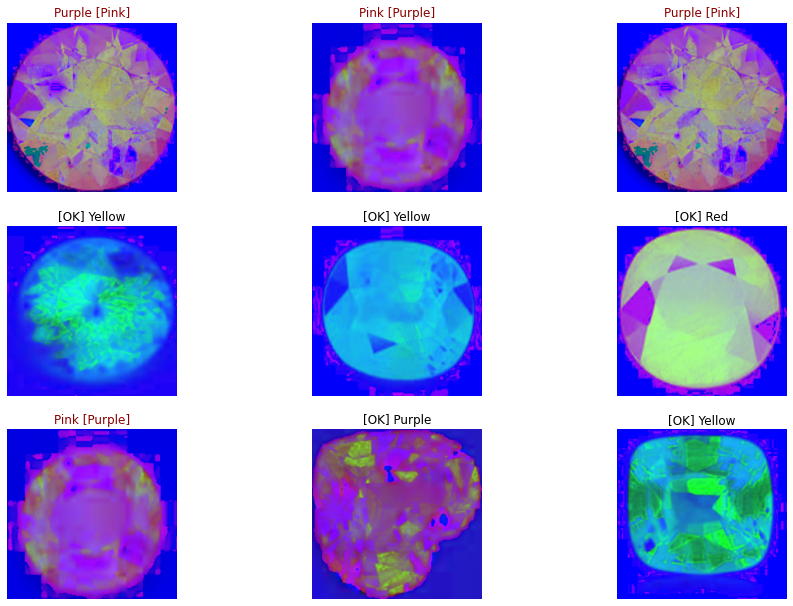

In [45]:
f,ax = plt.subplots(3,3) 
f.subplots_adjust(0,0,2,2)
for i in range(0,3,1):
    for j in range(0,3,1):
        rnd_number = randint(0,len(Test_Imgs))
        pred_image = np.array([Test_Imgs[rnd_number]])
        pred_class = model.predict_classes(pred_image)[0]
        pred_prob = model.predict(pred_image).reshape(5)
        act = CLASSES[Test_Lbls[rnd_number]]
        ax[i,j].imshow(Test_Imgs[rnd_number])
        ax[i,j].imshow(pred_image[0])
        if(CLASSES[pred_class] != CLASSES[Test_Lbls[rnd_number]]):
            t = '{} [{}]'.format(CLASSES[pred_class], CLASSES[Test_Lbls[rnd_number]])
            ax[i,j].set_title(t, fontdict={'color': 'darkred'})
        else:
            t = '[OK] {}'.format(CLASSES[pred_class]) 
            ax[i,j].set_title(t)
        ax[i,j].axis('off')